## **행렬 요인화 (Matrix Factorization)**
* 추천을 위한 다양한 알고리즘을 분류를 해보면 크게 메모리 기반(memory-based)과 모델 기반(model-based)으로 나눌 수 있다. 메모리 기반 알고리즘은 추천을 위한 데이터를 모두 메모리에 가지고 있으면서 추천이 필요할 때마다 이 데이터를 사용해서 계산을 해서 추천하는 방식을 말한다. 대표적으로 CF가 있다.
* 여기서 설명하는 MF 알고리즘은 대표적인 모델 기반 알고리즘으로, 원래 데이터는 모델을 만드는데에만 사용하고, 일단 모델이 만들어지면 원래 데이터는 사용하지 않기 때문에 계산이 빠르다.
* 일반적으로 메모리 기반 추천은 개별 사용자의 데이터에 집중하는 데 비해, 모델 기반 추천은 전체 사용자의 평가 패턴으로부터 모델을 구성하기 때문에, 데이터가 가지고 있는 약한 신호(weak signal)도 더 잘 잡아내는 경향이 있다.











Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9409 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9297 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9230 ; Test RMSE = 0.9524
Iteration: 50 ; Train RMSE = 0.9182 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9143 ; Test RMSE = 0.9478
Iteration: 70 ; Train RMSE = 0.9106 ; Test RMSE = 0.9464
Iteration: 80 ; Train RMSE = 0.9065 ; Test RMSE = 0.9452
Iteration: 90 ; Train RMSE = 0.9015 ; Test RMSE = 0.9438
Iteration: 100 ; Train RMSE = 0.8950 ; Test RMSE = 0.9421


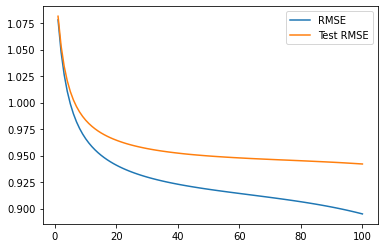

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/u.data', names = r_cols, sep='\t', encoding = 'latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

# train set과 test set을 나눈다.
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state = 1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings[:cutoff]
ratings_test = ratings[cutoff:]

class NEW_MF():

  # 변수 선언
  def __init__(self, ratings, K, alpha, beta, iterations, verbose = True):
    self.R = np.array(ratings)
    self.num_users, self.num_items = self.R.shape
    self.k = K # 요소 수
    self.alpha = alpha # 학습률
    self.beta = beta # 규제 정도
    self.iterations = iterations # 반복수
    self.verbose = verbose

    # item id와 user id를 순서대로 인덱싱한다.
    self.R = np.array(ratings)
    item_id_index = []
    index_item_id = []
    for i, one_id in enumerate(ratings):
      item_id_index.append([one_id, i])
      index_item_id.append([i,one_id])
    self.item_id_index = dict(item_id_index)
    self.index_item_id = dict(index_item_id)
    user_id_index = []
    index_user_id = []
    for i, one_id in enumerate(ratings):
      user_id_index.append([one_id, i])
      index_user_id.append([i, one_id])
    self.user_id_index = dict(user_id_index)
    self.index_user_id = dict(index_user_id)

  # test set을 코드에 맞게 형태를 바꾼다.
  def set_test(self, ratings_test):
    test_set = []
    for i in range(len(ratings_test)):
      x = self.user_id_index[ratings_test.iloc[i, 0]]
      y = self.item_id_index[ratings_test.iloc[i, 1]]
      z = ratings_test.iloc[i, 2]

      test_set.append([x, y, z])
      self.R[x, y] = 0
    self.test_set = test_set
    return test_set

  # Test RMSE 계산
  def test_rmse(self):
    error = 0
    for one_set in self.test_set:
      predicted = self.get_one_prediction(one_set[0], one_set[1])
      error += pow(one_set[2] - predicted, 2)
    return np.sqrt(error / len(test_set))

  # RMSE 계산
  def rmse(self):
    xs, ys = self.R.nonzero()
    self.predictions = []
    self.errors = []
    for x, y in zip(xs, ys):
      prediction = self.get_one_prediction(x, y)
      self.errors.append(self.R[x, y] - prediction)
    self.predictions = np.array(self.predictions)
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors ** 2))

  def test(self):
    self.P = np.random.normal(scale=1./self.k, size = (self.num_users, self.k))
    self.Q = np.random.normal(scale = 1./self.k, size=(self.num_items, self.k))
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    rows, columns = self.R.nonzero()
    self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]
    training_process = []
    
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse1 = self.rmse()
      rmse2 = self.test_rmse()
      training_process.append((i+1, rmse1, rmse2))
      if self.verbose:
        if (i+1) % 10 == 0:
          print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
    return training_process

  # 경사하강법 수행
  def sgd(self):
    for i, j, r in self.samples:
      prediction = self.get_one_prediction(i, j)
      e = (r-prediction)

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

      self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
      self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])

  def get_one_prediction(self, user_id, item_id):
    return np.dot(self.P[user_id, :], self.Q[item_id,:]) + self.b_u[user_id] + self.b_d[item_id] + self.b
  
  def full_prediction(self):
    return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + np.dot(self.P, self.Q.T)

R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
results = mf.test()

# 결과값 그리기
results = np.array(results)
plt.plot(results[:, 0], results[:, 1], label = 'RMSE')
plt.plot(results[:, 0], results[:, 2], label = 'Test RMSE')
plt.legend()
plt.show()


## **MF의 최적 파라미터 찾기**
* MF 알고리즘에서는 iterations(반복 횟수), K(잠재 요인 수), alpha(학습률), beta(규제화 정도) 같은 수 많은 하이퍼 파라이터들이 사용되며, 이러한 하이퍼 파라이터들을 최적화 하기 위해 모델을 튜닝해야 한다.
* K같은 경우, 모델의 가중치 개수를 결정하는 요인인데, 이 K가 많을 수록 예측 정확도는 높아질 것이다. 그러나, 너무 많아지면 overfitting이 일어날 수 있으므로 적절한 값을 찾을 필요가 있다.

In [ ]:
# 최적의 K를 찾기위해 50~ 260까지 10씩 증가시키며 SGD를 실행한다.
results = []
index = []
for K in range(50, 260, 10):
  print('k =', K)
  R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
  mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
  test_set = mf.set_test()
  result = mf.test()
  index.append(K)
  results.append(result)

# 각 K값마다 최소의 RMSE를 반환하는 iterations과, 최소의 RMSE 값을 저장한다.
summary = []
for i in range(len(results)):
  RMSE = []
  for result in results[i]:
    RMSE.append(result[2]))
  min = np.min(RMSE)
  j = RMSE.index(min)
  summary.append([index[i], j+1, RMSE[j]])

plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

1.007633929920189